# Baseline: Logistic Regression + TF-IDF

In this notebook I'm going to create a strong baseline model using classic ML algorithms. 

In [1]:
# !pip install skl2onnx==1.12.0 onnxruntime==1.13.1 protobuf==3.20.1 optuna==3.0.4
# !pip install --no-cache-dir git+https://github.com/optuna/optuna

## Imports

In [41]:
# import nltk
# nltk.download("stopwords")

In [6]:
import os
import gc
import gzip
import pickle
from pathlib import Path
import numpy as np
from collections import Counter
from pprint import pprint

In [42]:
import shap
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import optuna
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Parameters

In [9]:
SEED = 42

In [10]:
F1_AVERAGING = "macro"

VERSION = "0.3.0"

## Paths

### Input

In [11]:
RELATIVE_PATH = os.path.join("../", "data")

### Output

In [12]:
SAVED_MODELS_PATH = "saved_models"
Path(SAVED_MODELS_PATH).mkdir(parents=True, exist_ok=True)

In [13]:
PICKLE_VECTORIZER_PATH = os.path.join(
    SAVED_MODELS_PATH, f"TfIdfLogRegSentiment_vectorizer_{VERSION}.pkl"
)

PICKLE_VECTORIZER_PATH

'saved_models/TfIdfLogRegSentiment_vectorizer_0.3.0.pkl'

In [14]:
PICKLE_LOGREG_PATH = os.path.join(
    SAVED_MODELS_PATH, f"TfIdfLogRegSentiment_logreg_{VERSION}.pkl"
)

PICKLE_LOGREG_PATH

'saved_models/TfIdfLogRegSentiment_logreg_0.3.0.pkl'

## Loading data

In [15]:
class_col = "label"
text_col = "text"

In [16]:
reviews = pd.read_parquet(os.path.join(RELATIVE_PATH, "split_reviews.parquet"))
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206537 entries, 0 to 206536
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   label   206537 non-null  category
 1   text    206537 non-null  object  
 2   fold    206537 non-null  object  
dtypes: category(1), object(2)
memory usage: 3.3+ MB


In [17]:
train = reviews[reviews["fold"] == "train"]
test = reviews[reviews["fold"] == "test"]
dev = reviews[reviews["fold"] == "dev"]

del reviews
gc.collect()

0

In [18]:
X_train, X_test, X_dev, y_train, y_test, y_dev = (
    train[text_col].values.tolist(),
    test[text_col].values.tolist(),
    dev[text_col].values.tolist(),
    train[class_col].values.tolist(),
    test[class_col].values.tolist(),
    dev[class_col].values.tolist(),
)

del train, test, dev
gc.collect()

len(X_train), len(X_test), len(X_dev), len(y_train), len(y_test), len(y_dev)

(175556, 15490, 15491, 175556, 15490, 15491)

## Evaluation metrics

In [19]:
target_counts = Counter(y_test + y_dev)

total = sum(target_counts.values(), 0.0)
for key in target_counts:
    target_counts[key] /= total

print(target_counts)

Counter({'positive': 0.7202801717181498, 'neutral': 0.15002743617055614, 'negative': 0.12969239211129402})


Taking into account the distribution of the target, I will select the F1-score with macro-averaging, and we will use the F1-score with micro-averaging to illustrate the difference.

## Investigation

For baseline model, I've decided to start with TF-IDF and Logistic Regression.

### Text Encoding

#### Hyperparameter Investigation

Instead of using `TfidfVectorizer` to check different hyperparameters it will be faster to use `CountVectorizer`, because it has almost the same hyperparameters.

##### `lowercase`

In [15]:
vectorizer = CountVectorizer(lowercase=False)
vectors_wo_lowercase = vectorizer.fit_transform(X_train)

print(
    f"The size of the train dataset is {vectors_wo_lowercase.shape} with lowercase turned off"
)

The size of the train dataset is (175556, 767258) with lowercase turned off


In [16]:
vectorizer = CountVectorizer()
vectors_w_lowercase = vectorizer.fit_transform(X_train)

print(
    f"The size of the train dataset is {vectors_w_lowercase.shape} with lowercase turned on"
)

The size of the train dataset is (175556, 653993) with lowercase turned on


In [17]:
vectors_wo_lowercase.shape[1] - vectors_w_lowercase.shape[1]

113265

The difference in vocabulary size between cased and uncased models is more than 100 000, so we better stick to lowercase 

##### `max_df` and `min_df`

`min_df` is used for removing terms that appear **too infrequently**. For example:

 - `min_df = 0.01` means "ignore terms that appear in **less than 1% of the documents**".
 - `min_df = 5` means "ignore terms that appear in **less than 5 documents**".  
 
The default `min_df` is `1`, which means "ignore terms that appear in **less than 1 document**".  
Thus, the default setting does not ignore any terms.

`max_df` is used for removing terms that appear **too frequently**, also known as "corpus-specific stop words". For example:

 - `max_df = 0.5` means "ignore terms that appear in **more than 50% of the documents**".
 - `max_df = 25` means "ignore terms that appear in **more than 25 documents**".  
 
The default `max_df` is `1.0`, which means "ignore terms that appear in **more than 100% of the documents**".  
Thus, the default setting does not ignore any terms.

In [18]:
vectorizer.get_feature_names_out()[:50]

array(['00', '000', '0000', '00000', '000000',
       '000000000000000000попкорн000000000000', '000000000000001',
       '000000000000на', '00000000000во', '00000000000данной',
       '00000000000есть000000000000000',
       '00000000000есть000000000000000000', '0000000000жевать',
       '0000000000ненавижу00000000', '00000000016', '000000000надо',
       '000000000разговаривать0000000000', '00000000визуальная',
       '00000001', '00000громко', '00000точек', '00001', '00007', '0001',
       '0002', '000доктора', '000какой', '000косметические', '000р',
       '000теряются', '001', '002', '003', '00381', '006', '007', '00в',
       '00вых', '00м', '00по', '00с', '00х', '00ые', '00ых', '01', '011',
       '013', '014', '01минуту', '01ч37мин'], dtype=object)

We can see that if we do not limit the vocabulary, we will have very infrequent words in the corpora, so we better do it.  
For that we have to choose the `min_df` and `max_df` thresholds.

In [19]:
vectorizer = CountVectorizer(min_df=0.8)
vectors = vectorizer.fit_transform(X_train)
vectors.shape

(175556, 7)

In [20]:
vectorizer.get_feature_names_out()

array(['как', 'на', 'не', 'но', 'то', 'что', 'это'], dtype=object)

These words are in 80% of all reviews, and this is understandable, since these are particles, prepositions and conjunctions.

In [21]:
MIN_DF = 0.01
vectorizer = CountVectorizer(min_df=MIN_DF)
vectors = vectorizer.fit_transform(X_train)

print(
    f"The size of the train dataset is {vectors.shape} with lowercase turned on and min_df={MIN_DF}"
)

The size of the train dataset is (175556, 3286) with lowercase turned on and min_df=0.01


In [22]:
vectorizer.get_feature_names_out()[:50]

array(['10', '100', '11', '12', '13', '15', '16', '18', '20', '2012',
       '21', '30', '3d', '40', '50', '60', '70', '80', '90', 'dc',
       'marvel', 'of', 'the', 'абсолютно', 'аватар', 'автор', 'автора',
       'авторов', 'авторы', 'аж', 'актер', 'актера', 'актерам',
       'актерами', 'актерах', 'актеров', 'актером', 'актерская',
       'актерский', 'актерского', 'актерской', 'актерскую', 'актеры',
       'актриса', 'актрисы', 'актёр', 'актёра', 'актёров', 'актёрская',
       'актёрский'], dtype=object)

Now it's much better. We removed unpopular tokens and reduced the vocabulary from ~670K to 3.3K tokens.

In [23]:
MIN_DF = 0.01
MAX_DF = 0.9

vectorizer = CountVectorizer(min_df=MIN_DF, max_df=MAX_DF)
vectors = vectorizer.fit_transform(X_train)

print(
    f"The size of the train dataset is {vectors.shape} with lowercase turned on and min_df={MIN_DF} and max_df={MAX_DF}"
)

The size of the train dataset is (175556, 3283) with lowercase turned on and min_df=0.01 and max_df=0.9


I'll leave default value of `max_df` - 1.

##### `ngram_range`

The lower and upper boundary of the range of n-values for different n-grams to be extracted.  
All values of n such that min_n ≤ n ≤ max_n will be used.   

For example a `ngram_range` of `(1, 1)` means only `unigrams`, `(1, 2)` means `unigrams` and `bigrams`, and `(2, 2)` means only `bigrams`.

In [24]:
NGRAM_RANGE = (1, 2)
MIN_DF = 0.01

vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, min_df=MIN_DF)

train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
dev_vectors = vectorizer.transform(X_dev)

print(
    f"The size of the train dataset is {train_vectors.shape} with lowercase turned on and min_df={MIN_DF} and ngram_range={NGRAM_RANGE}"
)

The size of the train dataset is (175556, 4624) with lowercase turned on and min_df=0.01 and ngram_range=(1, 2)


In [25]:
vectorizer.get_feature_names_out()[:50]

array(['10', '10 лет', '100', '11', '12', '13', '15', '16', '18', '20',
       '2012', '21', '30', '3d', '40', '50', '60', '70', '80', '90', 'dc',
       'marvel', 'of', 'the', 'абсолютно', 'абсолютно все',
       'абсолютно не', 'аватар', 'автор', 'автора', 'авторов', 'авторы',
       'аж', 'актер', 'актера', 'актерам', 'актерами', 'актерах',
       'актеров', 'актером', 'актерская', 'актерская игра', 'актерский',
       'актерский состав', 'актерского', 'актерской', 'актерской игры',
       'актерскую', 'актерскую игру', 'актеры'], dtype=object)

From my experience, usually `(1, 2)` is a good default value for the `ngram_range`. Sometimes `(1, 3)` can be a little bit better.

### Classification

For the base model, I always use logistic regression as a classifier.

In [26]:
log_reg = LogisticRegression(
    random_state=SEED, class_weight="balanced", solver="saga", max_iter=1_000
)
log_reg.fit(train_vectors, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='saga')

In [27]:
pred_labels = log_reg.predict(dev_vectors)
f1_micro = f1_score(y_dev, pred_labels, average="micro")
f1_macro = f1_score(y_dev, pred_labels, average="macro")

print(f"F1 score with micro-averaging is {f1_micro.round(5)}")
print(f"F1 score with macro-averaging is {f1_macro.round(5)}")

F1 score with micro-averaging is 0.72584
F1 score with macro-averaging is 0.62215


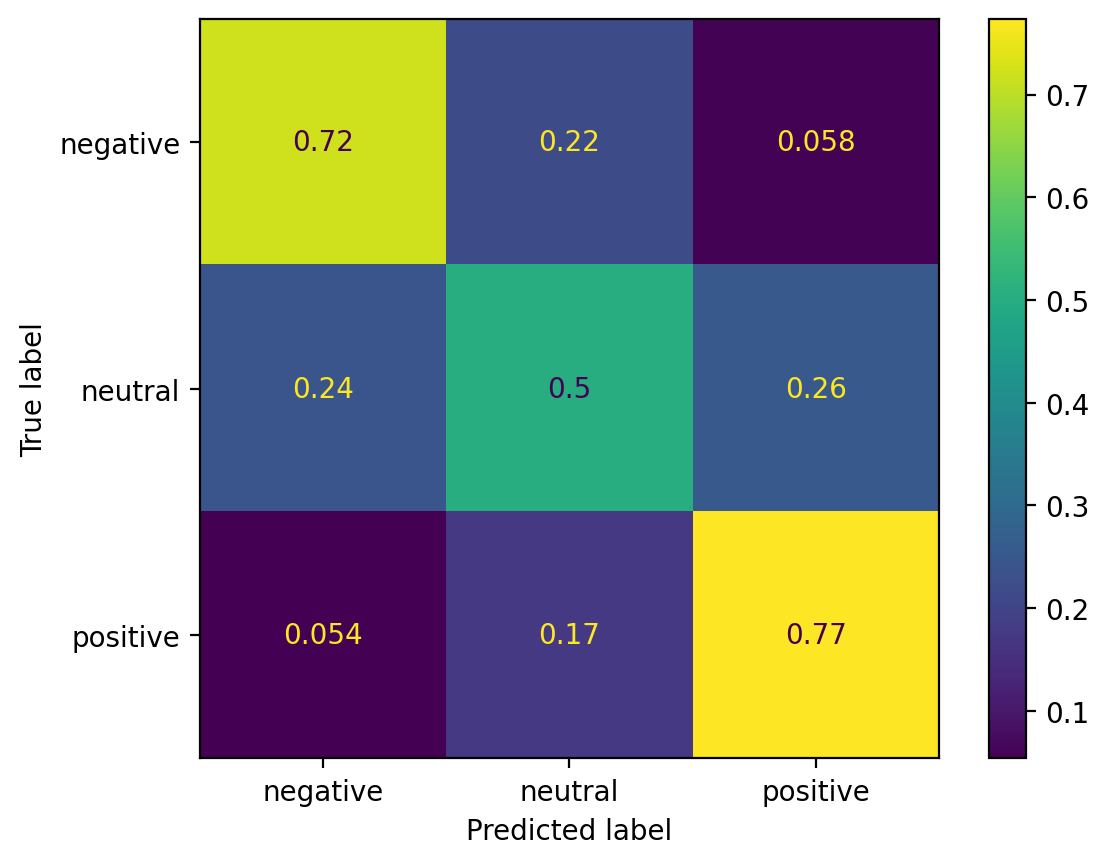

In [28]:
cm = confusion_matrix(y_dev, pred_labels, labels=log_reg.classes_, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)

disp.plot()

### Hyperparameter Tuning

For Logistic Regression we can tune the regularization strength (`C`), `solver` and `penalty` type.  
In this notebook, I will only tune the first one using Optuna.

For TF-IDF ...

In [ ]:
stopwords_to_remove = [""]

In [45]:
russian_stopwords = stopwords.words("russian")
russian_stopwords[::10]

['и',
 'как',
 'к',
 'было',
 'когда',
 'был',
 'потом',
 'ней',
 'будто',
 'этот',
 'почти',
 'никогда',
 'больше',
 'разве',
 'лучше',
 'между']

In [50]:
print(russian_stopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [37]:
distributions = {
    "ngram_range": optuna.distributions.CategoricalDistribution(
        choices=((1, 1), (1, 2), (1, 3))
    ),
    "min_df": optuna.distributions.IntDistribution(low=5, high=10),
    "lowercase": optuna.distributions.CategoricalDistribution(choices=(True, False))
}

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.


For hyperparameter tuning we will use only a fraction of the train data to speed up the process.

In [34]:
X_train_hyper, _, y_train_hyper, _ = train_test_split(
    X_train, y_train, test_size=0.9, random_state=SEED
)

len(X_train_hyper)

17555

In [35]:
study = optuna.create_study(direction="maximize")
n_trials = 20

[I 2024-02-02 10:14:50,240] A new study created in memory with name: no-name-35d394f8-ad23-4cb0-b5a6-ebbc7896d788


In [36]:
for _ in tqdm(range(n_trials)):
    trial = study.ask(distributions)

    vectorizer_params = {
        "min_df": trial.params["min_df"],
        "ngram_range": trial.params["ngram_range"],
        "lowercase": trial.params["lowercase"]
    }

    review_vectorizer = TfidfVectorizer(**vectorizer_params)
    train_vectors = review_vectorizer.fit_transform(X_train_hyper)

    clf = LogisticRegressionCV(
        cv=5,
        solver="saga",
        class_weight="balanced",
        max_iter=1_000,
        random_state=SEED,
    )
    clf.fit(train_vectors, y_train_hyper)

    pred_labels = clf.predict(dev_vectors)
    f1 = f1_score(y_dev, pred_labels, average=F1_AVERAGING)

    study.tell(trial, f1)

  0%|          | 0/20 [06:39<?, ?it/s]


NameError: name 'log_reg' is not defined

In [ ]:
study.best_params, study.best_value

({'C': 6.910877670014768e-06}, 0.6221531301627613)

Let's now make a simple pipeline with two components: `TfidfVectorizer` and `LogisticRegression` to save model in one file.

## Modelling

### Vectorizing reviews with TF-IDF

#### Train

In [25]:
vectorizer_params = {
    # "min_df": 0.01,
    "ngram_range": (1, 3),
    "max_features": 100_000,
}

review_vectorizer = TfidfVectorizer(**vectorizer_params)

In [ ]:
review_vectorizer.fit_transform(X_train)

#### Save

In [41]:
with gzip.open(PICKLE_VECTORIZER_PATH, "wb") as f:
    pickle.dump(review_vectorizer, f)

#### Load

In [14]:
with gzip.open(PICKLE_VECTORIZER_PATH, "rb") as f:
    review_vectorizer = pickle.load(f)

#### Transform

In [15]:
train_vectors = review_vectorizer.transform(X_train)

### Classifying reviews with Logistic Regression

#### Train

In [16]:
log_reg = LogisticRegression(
    # C=1,
    penalty="l1",
    random_state=SEED,
    solver="saga",
    max_iter=5000,
    class_weight="balanced",
    verbose=1,
)

In [17]:
log_reg.fit(train_vectors, y_train)

Epoch 1, change: 1.00000000
Epoch 2, change: 0.39796686
Epoch 3, change: 0.20255005
Epoch 4, change: 0.17754637
Epoch 5, change: 0.14364051
Epoch 6, change: 0.14873144
Epoch 7, change: 0.11509555
Epoch 8, change: 0.11013361
Epoch 9, change: 0.13738366
Epoch 10, change: 0.10921248
Epoch 11, change: 0.09994089
Epoch 12, change: 0.10122932
Epoch 13, change: 0.09576989
Epoch 14, change: 0.09133063
Epoch 15, change: 0.08457056
Epoch 16, change: 0.09801357
Epoch 17, change: 0.09413728
Epoch 18, change: 0.10664590
Epoch 19, change: 0.09308614
Epoch 20, change: 0.08456965
Epoch 21, change: 0.08676320
Epoch 22, change: 0.07986458
Epoch 23, change: 0.08511756
Epoch 24, change: 0.08233221
Epoch 25, change: 0.07404686
Epoch 26, change: 0.08959467
Epoch 27, change: 0.08866488
Epoch 28, change: 0.07374409
Epoch 29, change: 0.07365152
Epoch 30, change: 0.07140203
Epoch 31, change: 0.06406793
Epoch 32, change: 0.07518060
Epoch 33, change: 0.06779344
Epoch 34, change: 0.07569979
Epoch 35, change: 0.082

#### Save

In [ ]:
with gzip.open(PICKLE_LOGREG_PATH, "wb") as f:
    pickle.dump(log_reg, f)

#### Load

In [ ]:
with gzip.open(PICKLE_LOGREG_PATH, "rb") as f:
    log_reg = pickle.load(f)

### Evaluation

In [23]:
test_vectors = review_vectorizer.transform(X_test)
# dev_vectors = review_vectorizer.transform(X_dev)

In [24]:
pred_labels = log_reg.predict(test_vectors)
f1 = f1_score(y_test, pred_labels, average=F1_AVERAGING)

print(f"F1 score with {F1_AVERAGING}-averaging is {f1.round(5)}")

F1 score with macro-averaging is 0.65248


Now we have our pipeline and we can save it.  
We have several choices: ONNX, joblib, pickle.

## Error analysis

### Loading Models

In [ ]:
with gzip.open(PICKLE_LOGREG_PATH, "rb") as f:
    log_reg = pickle.load(f)

### Making Predictions

In [15]:
pred_labels = pipe.predict(X_test)
f1_loaded = f1_score(y_test, pred_labels, average=F1_AVERAGING)

print(f"F1 score with {F1_AVERAGING}-averaging is {f1_loaded.round(5)}")

F1 score with macro-averaging is 0.65308


### Confusion Matrices

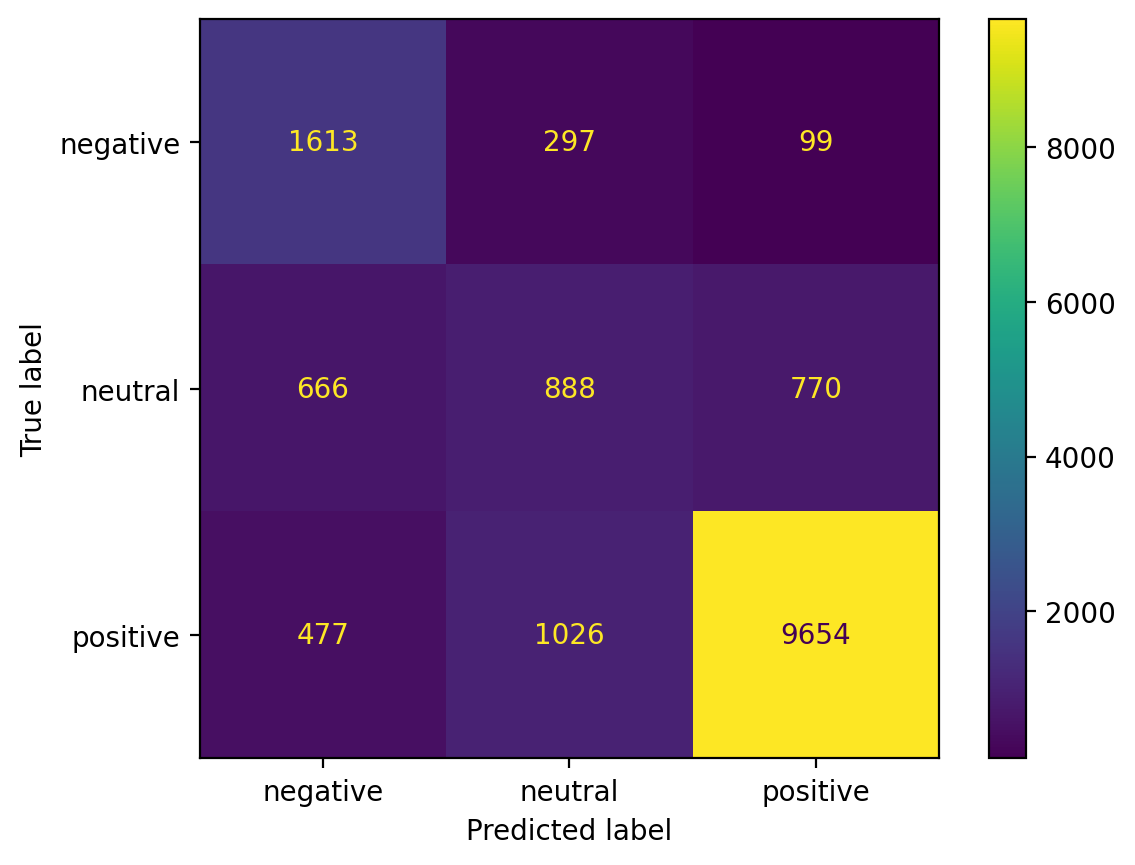

In [16]:
cm = confusion_matrix(y_test, pred_labels, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

disp.plot()

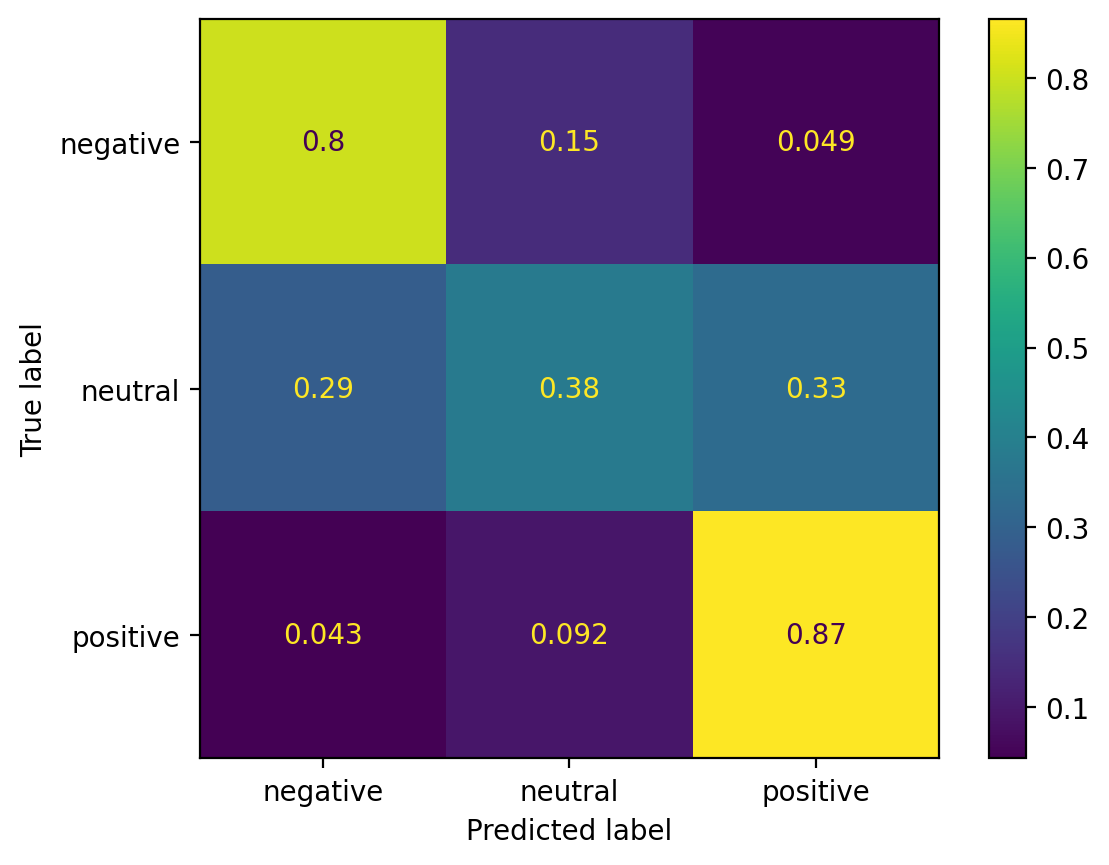

In [17]:
cm = confusion_matrix(y_test, pred_labels, labels=pipe.classes_, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

disp.plot()

- The most problematic class is *neutral*. It can be easily be mistaken for negative (29% objects) and positive (33% objects) classes. 
- 15% of negative labels were predicted as neutral. 
- 9% of positive labels were predicted as neutral. 

### Looking at the errors

Let's look not only at the predicted labels, but also at the probabilities.  

For that we will use `predict_proba` method:

In [18]:
pred_proba = pipe.predict_proba(X_test)

pred_proba

array([[0.13586208, 0.25573678, 0.60840114],
       [0.06425165, 0.26806429, 0.66768406],
       [0.41113839, 0.16044847, 0.42841314],
       ...,
       [0.23929967, 0.33224083, 0.4284595 ],
       [0.01366047, 0.10231875, 0.88402078],
       [0.85966708, 0.12172115, 0.01861177]])

To determine the order of the classes we will use `classes_` attribute:

In [19]:
pipe.classes_

array(['negative', 'neutral', 'positive'], dtype='<U8')

Now it's time to merge `pred_proba` and `pipe.classes_` for better readability:

In [20]:
y_pred = [dict(zip(pipe.classes_, pred)) for pred in pred_proba]
y_pred[0:3]

[{'negative': 0.1358620779857563,
  'neutral': 0.25573678293134106,
  'positive': 0.6084011390829027},
 {'negative': 0.06425165370383355,
  'neutral': 0.26806429058615266,
  'positive': 0.6676840557100138},
 {'negative': 0.4111383876459033,
  'neutral': 0.16044847366747364,
  'positive': 0.42841313868662306}]

Let's determine the indices of our errors:

In [21]:
error_indices = np.where((y_test != pred_labels).astype(int) == 1)[0]
error_indices

array([    6,    11,    16, ..., 15479, 15482, 15484])

Looking at the errors:

In [22]:
for error_index in error_indices[:3]:
    print(f"Actual label: {y_test[error_index]}")
    print(f"Predicted label: {pred_labels[error_index]}")
    print(f"Probabilities :{y_pred[error_index]}\n")

    pprint(X_test[error_index], width=160)
    print("\n")

Actual label: neutral
Predicted label: negative
Probabilities :{'negative': 0.7628465392601909, 'neutral': 0.19242844458829406, 'positive': 0.04472501615151515}

('Говорят, опытный читатель может раскрыть загадку преступления ещё в первой главе, но дело здесь, увы, не в гениальности любителя мягкопереплетной желтой '
 'прессы, а в посредственности писак. Современные детективы я не люблю, по привычке предпочитая им Шерлока Холмса и Агату Кристи. Не так давно мне выдалось '
 "посмотреть экранизацию одного мирового бестселлера. По крайней мере, в афише 'Девушка с татуировкой дракона' была обозначена именно так. Трагедия семьи "
 'Вангер заинтересовала меня, но в общем фильм показался серым, грязным мотанием пленки на 2 часа и 40 минут, с огромным количеством ненужных подробностей и '
 'жестких сцен. Словом, сценарий был написан не слишком удачно. Картину не спас и звездный состав, хотя Руни Мара довольно-таки сносно влилась в образ Лисбет '
 '(разве что бровей добавить), тогда как Дэниэл 

## Explaining Predictions

### SHAP

https://shap.github.io/shap/notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.html

## To Do

- Follow the article https://developers.google.com/machine-learning/guides/text-classification?hl=en
- Adding stopwords, but filter them using top-N trigrams not to loose important words
- Saving fitted vectorizer separately (this way we can use different models on the same features)
- Explaining predictions